# Information Extraction

In [4]:
# Load Libraries
import pandas as pd
import nltk
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tree import Tree
import spacy
import re

pd.set_option('display.max_rows', None)   # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust the width to display full table
pd.set_option('display.max_colwidth', None)  # Adjust column width to avoid truncation


## Format Data

In [7]:
df = pd.read_csv("filter_50krows.csv")


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   From                       50000 non-null  object
 1   To                         50000 non-null  object
 2   Subject                    50000 non-null  object
 3   X-cc                       50000 non-null  object
 4   X-bcc                      50000 non-null  object
 5   Job_Title                  50000 non-null  object
 6   Total_Sentence_Word_Count  50000 non-null  int64 
 7   From_Names                 49962 non-null  object
 8   To_Names                   49263 non-null  object
 9   Cleaned_Content            50000 non-null  object
 10  BoW                        50000 non-null  object
 11  DateTime                   50000 non-null  object
dtypes: int64(1), object(11)
memory usage: 4.6+ MB


## NER

### NER Function

In [12]:
import pandas as pd
from tqdm.notebook import tqdm
import spacy
import time

# Enable tqdm for pandas
tqdm.pandas()

# Time the loading of the spaCy model
print("Loading spaCy model...")
start_time = time.time()
nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser", "lemmatizer"])
model_load_time = time.time() - start_time
print(f"Model loaded in {model_load_time:.2f} seconds")

# Function to extract named entities for a single text
def extract_named_entities_spacy(text):
    """
    Extracts named entities from a single text using spaCy's pre-trained model.
    
    Args:
        text (str): The text to process.
    
    Returns:
        list: A list of (entity, label) tuples for the text.
    """
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents if ent.text.strip()]
    return entities


# Apply NER extraction with timing and progress_apply
start_time = time.time()
print("Applying NER to DataFrame...")
df['NER_Entities'] = df['Cleaned_Content'].progress_apply(extract_named_entities_spacy)
total_time = time.time() - start_time
print(f"Total application time: {total_time:.2f} seconds")



Loading spaCy model...
Model loaded in 3.34 seconds
Applying NER to DataFrame...


  0%|          | 0/50000 [00:00<?, ?it/s]

Total application time: 1821.68 seconds


In [14]:
df.to_csv('filtered_50krows_NER_Entities.csv', index=False)

### Run NER on Content

#### From NER results on Content column, there are several errors that need to be rectified:

- Remove enronenron name, OR trim names that end with enronenron OR corp enronenron
- Remove ect name, or trim names that end with ect
- Trim names that end with "hou"
- There are multiple instances of the same name in different formats (e.g. phillip k allen = phillip allen = pallen, kristin walsh = kristin)

## Dependency Parsing in Content (CRASHED -> currently fixing)

In [ ]:
from joblib import Parallel, delayed  # For multiprocessing

# Load a Faster NLP Model
nlp = spacy.load("en_core_web_lg", disable=["parser", "tagger"])

def extract_relationships(doc):
    persons = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    return [(p1, p2) for i, p1 in enumerate(persons) for p2 in persons[i+1:]]

def process_batch(batch_texts):
    """
    Processes a batch of texts and extracts relationships.
    Each process loads its own instance of the NLP model.
    """
    nlp = spacy.load("en_core_web_lg", disable=["parser", "tagger"])  # Load within function
    docs = list(nlp.pipe(batch_texts, batch_size=200))  
    return [extract_relationships(doc) for doc in docs]


# Split into batches for multiprocessing
num_cores = -1  # Use all available CPU cores
batch_size = 200  
batches = [df['Content'][i:i + batch_size] for i in range(0, len(df), batch_size)]

# Batch process data in parallel
results = Parallel(n_jobs=num_cores)(delayed(process_batch)(batch) for batch in batches)

# Flatten results
df['parsed_relationships'] = [rel for batch_result in results for rel in batch_result]

# View results
print(df[['Content', 'parsed_relationships']])

## Co-occurrence Patterns between Sender & Recipient Pairs

In [ ]:
# Function to build a co-occurrence network
def build_cooccurrence_network(df):
    cooccurrence_graph = nx.Graph()

    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        entities_from = row['From_Names']
        entities_to = row['To_Names']

        # Ensure values are lists (if stored as strings, split them)
        if isinstance(entities_from, str):
            entities_from = entities_from.split(", ")
        if isinstance(entities_to, str):
            entities_to = entities_to.split(", ")

        # Combine senders and recipients into a unique set
        all_entities = set(entities_from + entities_to)

        # Generate co-occurring pairs
        for person1, person2 in combinations(all_entities, 2):
            if cooccurrence_graph.has_edge(person1, person2):
                cooccurrence_graph[person1][person2]['weight'] += 1
            else:
                cooccurrence_graph.add_edge(person1, person2, weight=1)
    return cooccurrence_graph

# Build the co-occurrence network
cooccurrence_network = build_cooccurrence_network(df)

# Get the top co-occurring pairs by weight
sorted_edges = sorted(cooccurrence_network.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
print("Top Co-occurring Pairs:", sorted_edges[:10])

Top Co-occurring Pairs: [('vince kaminski', 'vkaminski', {'weight': 3998}), ('steven kean', 'richard shapiro', {'weight': 2530}), ('jeff dasovich', 'susan mara', {'weight': 2098}), ('james steffes', 'richard shapiro', {'weight': 2080}), ('jeff dasovich', 'richard shapiro', {'weight': 1797}), ('kay mann', 'suzanne adams', {'weight': 1770}), ('james steffes', 'jeff dasovich', {'weight': 1765}), ('evelyn metoyer', 'kate symes', {'weight': 1710}), ('vince kaminski', 'shirley crenshaw', {'weight': 1650}), ('mark taylor', 'sara shackleton', {'weight': 1533}), ('angela schwarz', 'beverly aden', {'weight': 1464}), ('alan comnes', 'angela schwarz', {'weight': 1454}), ('jeff dasovich', 'alan comnes', {'weight': 1450}), ('alan comnes', 'beverly aden', {'weight': 1449}), ('ben jacoby', 'kay mann', {'weight': 1382}), ('outlook team', '', {'weight': 1335}), ('steven kean', 'maureen mcvicker', {'weight': 1316}), ('no address', 'worldwide', {'weight': 1306}), ('james steffes', 'steven kean', {'weight'

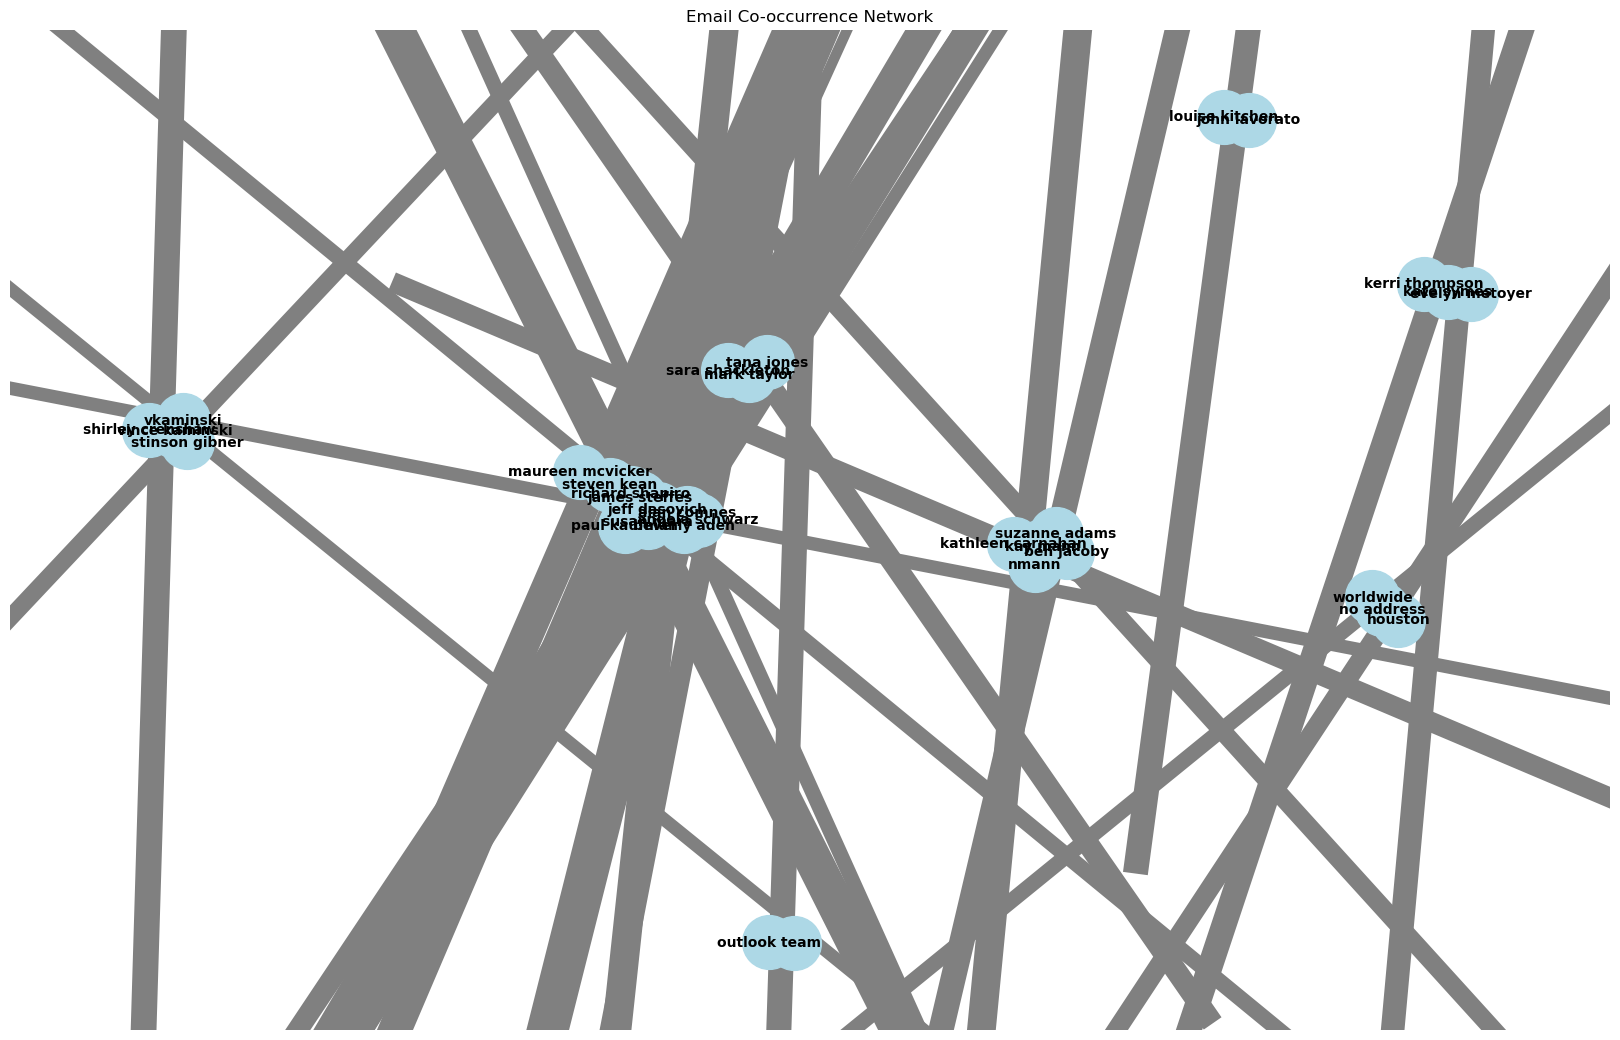

In [ ]:
# Visualise Co-occurance Network in a Graph

def filter_edges(graph, min_weight=1000):
    filtered_graph = nx.Graph()
    for u, v, data in graph.edges(data=True):
        if data["weight"] >= min_weight:
            filtered_graph.add_edge(u, v, weight=data["weight"])
    return filtered_graph


# Visualize the co-occurrence network
def visualize_cooccurrence_network(graph):
    plt.figure(figsize=(16, 10))

    # Node positions (spring layout)
    pos = nx.spring_layout(graph, seed=42)

    # Extract edge weights for line thickness
    edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]

    # Draw the network
    nx.draw(graph, pos, with_labels=True, node_size=1500, node_color='lightblue',
            font_size=10, font_weight='bold', edge_color='gray', width=edge_weights)

    # Display the graph
    plt.title("Email Co-occurrence Network")
    plt.show()


# Filter edges with a weight less than 3
cooccurrence_network_filtered = filter_edges(cooccurrence_network, min_weight=1000)
# Display the top co-occurring pairs by weight
sorted_edges = sorted(cooccurrence_network_filtered.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
print("Top Co-occurring Pairs:", sorted_edges[:20])

visualize_cooccurrence_network(cooccurrence_network_filtered)

## Work In Progress

### Apply NER on To & From Columns (Not reccomended)

In [ ]:
# #  Load spaCy model
# nlp = spacy.load("en_core_web_sm")

# def extract_name_from_email(email):
#     name_part = email.split('@')[0]  # Get text before @
#     name_cleaned = re.sub(r'[\W\d_]', ' ', name_part)  # Replace non-alphabet characters with spaces
#     name_cleaned = " ".join(name_cleaned.split())  # Remove extra spaces
#     return name_cleaned.title()  # Convert to title case (e.g., "John Lavorato")

# def extract_named_entities_spacy(texts, batch_size=500):
#     # Convert all emails to readable names
#     cleaned_texts = [", ".join([extract_name_from_email(email) for email in text.split(",")]) for text in texts]

#     # Run spaCy NER on extracted names
#     docs = nlp.pipe(cleaned_texts, batch_size=batch_size, disable=["parser", "tagger"])

#     # Extract PERSON entities
#     entity_lists = [[ent.text for ent in doc.ents if ent.label_ == "PERSON"] for doc in docs]

#     return entity_lists

In [ ]:
## Apply the function with batch processing, takes approx 10 mins
## Uncomment below code if you want to run NER for To and From columns
# df['named_entities_to'] = extract_named_entities_spacy(df['To'], batch_size=500) 
# df['named_entities_from'] = extract_named_entities_spacy(df['From'], batch_size=500) 

## df.info()
## df.head(20)


# # Count the number of rows where names were identified
# count_non_empty_to = df[df['named_entities_to'].apply(lambda x: len(x) > 0)].shape[0]
# count_non_empty_from = df[df['named_entities_from'].apply(lambda x: len(x) > 0)].shape[0]

# print(f"Total number of rows: {df.shape[0]}")

# print(f"Number of rows where names_to were identified: {count_non_empty_to}")
# print(f"Percentage of rows where names_to were identified: {count_non_empty_to / df.shape[0] * 100:.2f}%")

# print(f"Number of rows where names_from were identified: {count_non_empty_from}")
# print(f"Percentage of rows where names_from were identified: {count_non_empty_from / df.shape[0] * 100:.2f}%")

### Relationship Extraction (in progress)

In [ ]:
# # Create a communication network dictionary
# communication_network = defaultdict(set)

# for index, row in df.iterrows():
#     sender = row['From']
#     receiver = row['To']
#     entities = row['named_entities']
    
#     # Establish relationships
#     for entity in entities:
#         communication_network[sender].add(entity)
#         communication_network[receiver].add(entity)

# # Convert dictionary to a list of sender-recipient pairs
# edges = []
# for sender, recipients in communication_network.items():
#     for recipient in recipients:
#         edges.append((sender, recipient))

### Social Network Analysis (in progress)

In [ ]:
# # Create a graph
# G = nx.Graph()
# G.add_edges_from(edges)

# # Compute centrality measures
# degree_centrality = nx.degree_centrality(G)
# betweenness_centrality = nx.betweenness_centrality(G)
# closeness_centrality = nx.closeness_centrality(G)

# # Print top 5 central figures in the network
# print("Top 5 by Degree Centrality:", sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
# print("Top 5 by Betweenness Centrality:", sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
# print("Top 5 by Closeness Centrality:", sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

In [ ]:
# plt.figure(figsize=(12, 8))
# nx.draw(G, with_labels=True, node_size=50, font_size=7, edge_color="gray")
# plt.title("Enron Employee Communication Network")
# plt.show()